<h2> (1) Import all relevant libraries, layer and classes <h2>


In [1]:
# General
import os
import time

# Python libraries
import numpy as np, collections
import pydot as pyd
import matplotlib.pyplot as plt
from IPython.display import SVG

# Tensorflow
import tensorflow as tf

# Keras
import keras.backend as k
from keras import optimizers
from keras import losses, regularizers
from keras import initializers
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot

# CoreML 
import coremltools

# Scikit-learn
from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold

# Seaborn
import seaborn as sn

# Locale methods and properties
from auxilary_functions import time_stamp
from load_data import load_and_store_data, load_stored_data 
from model import create_model
from callbacks import get_callbacks 
from plot_pose_sequence import plot_trainings_data, plot_test_data
from plot_confusion_matrix import print_confusion_matrix 
from plot_trainings_history import plot_loss_acc
from plot_data_distribution import plot_data_distribution

Using TensorFlow backend.
W0718 21:51:12.200201 140134388569920 __init__.py:71] TensorFlow version 1.14.0 detected. Last version known to be fully compatible is 1.13.1 .


<h2> (2) Load and prepare goalkeeper pose data <h2>

In [2]:
DATA_PATH = "./stored_data/"

# Load data from .npy files 
# (Framrates/Poses-per-sequence: '5' / '10' / '15' / '30' / '45' / '60' / '75' / '90')
X, y = load_stored_data(dir_path=DATA_PATH, num_poses='90')
# X = [samples, timesteps, features]
# y = [samples, labels]

# Split dataset into train and test set (and shuffle them)
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y, test_size = 0.1, random_state = 42)

# Get one hot vector from labels
y_train = to_categorical(y_train_temp, num_classes=6)
y_test = to_categorical(y_test_temp, num_classes=6)

# Input features
INPUT = [
    "HEAD_X",
    "HEAD_Y_",
    "BODY_X",
    "BODY_Y",
    "LEFT_ARM_X",
    "LEFT_ARM_Y",
    "RIGHT_ARM_X",
    "RIGHT_ARM_Y",
    "LEFT_LEG_X",
    "LEFT_LEG_Y",
    "RIGHT_LEG_X",
    "RIGHT_LEG_Y",
]

# Output classes
LABELS = [    
    "STAND_BY",
    "LEFT_DIVE",
    "LONG_LEFT_DIVE",
    "RIGHT_DIVE",
    "LONG_RIGHT_DIVE",
    "HIGH_CATCH",
]

# Some debugging info
print("---------------------------------------")
print("---------------------------------------")
print("Bsic information regardin the data:")
print("---------------------------------------")
print("Trainings data...")
print("... input shape=" + str(X_train.shape))
print("... target shape=" + str(y_train.shape))
print("---------------------------------------")
print("Test data...")
print("... input shape=" + str(X_test.shape))
print("... target shape=" + str(y_test.shape))
print("---------------------------------------")
print("---------------------------------------")

---------------------------------------
---------------------------------------
Bsic information regardin the data:
---------------------------------------
Trainings data...
... input shape=(1194, 90, 26)
... target shape=(1194, 6)
---------------------------------------
Test data...
... input shape=(133, 90, 26)
... target shape=(133, 6)
---------------------------------------
---------------------------------------


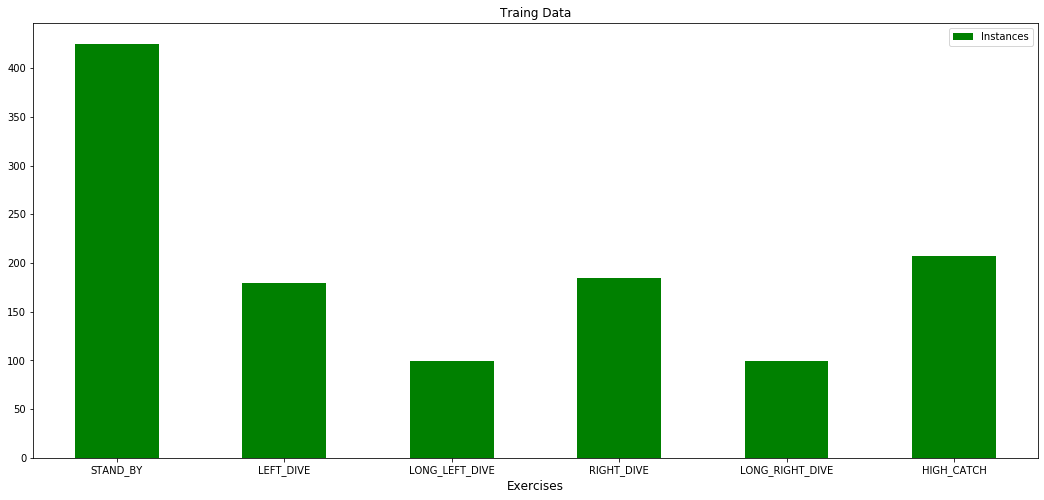

In [3]:
# Plot data distribution (trainings data)
plot_data_distribution(y_train_temp, labels=LABELS)

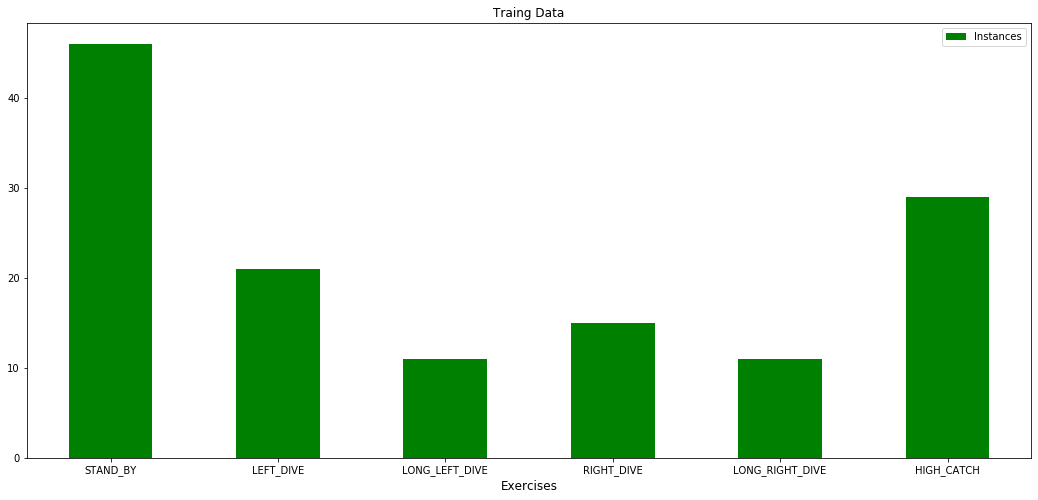

In [4]:
# Plot data distribution (teest data)
plot_data_distribution(y_test_temp, labels=LABELS)

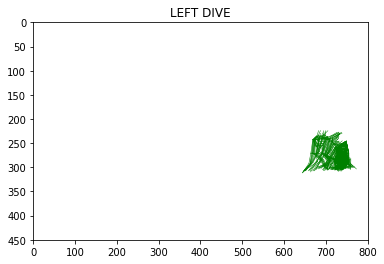

In [5]:
# Plot one sequence of poses
plot_trainings_data(X_train, y_train_temp, sample=25)

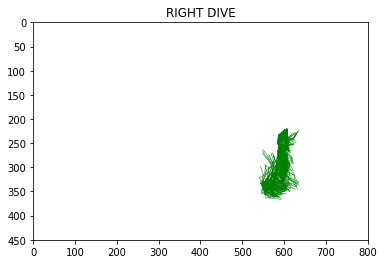

In [6]:
# Plot one sequence of poses
plot_trainings_data(X_train, y_train_temp, sample=845)

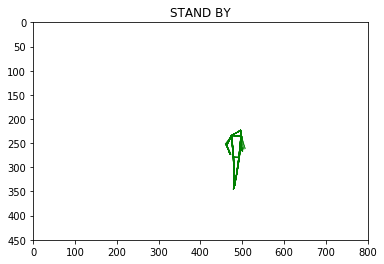

In [7]:
# Plot one sequence of poses
plot_trainings_data(X_train, y_train_temp, sample=103)

<h2> (3) Define constants and additional parameters <h2>

In [8]:
# Input Data
n_timesteps = X_train.shape[1] #len(X_train[1])  # n-timesteps per series per series
n_features = X_train.shape[2] #len(X_train[0][0])  # n input parameters per timestep

# LSTM Neural Network's internal structure
input_shape = (n_timesteps, n_features)
n_mem_units = 200 # Hidden layer num of features
n_classes = len(LABELS) # n classes (should go up, or should go down)

# Training - Hyperparameter  
learning_rate = 0.001
optimizer = optimizers.Adam(lr=learning_rate, decay=0.5) 
n_epochs = 42  
batch_size = 24

<h2> (4) Define and build sequence model <h2>

In [10]:
# Create model
model = create_model(input_shape, dropout=True)

# Build model 
model.compile(loss=losses.categorical_crossentropy, 
              optimizer=optimizer,
              metrics=['mse', 'accuracy'])

# Print model details/summary
model.summary()

# Get curent time stamp
time_stamp = time_stamp()

W0718 21:51:40.769288 140134388569920 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 21:51:40.770390 140134388569920 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 21:51:40.785840 140134388569920 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 21:51:41.441374 140134388569920 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please us

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 90, 26)            0         
_________________________________________________________________
LSTM_Layer1 (LSTM)           (None, 90, 90)            42120     
_________________________________________________________________
LSTM_Layer2 (LSTM)           (None, 90, 90)            65160     
_________________________________________________________________
LSTM_Layer3 (LSTM)           (None, 90)                65160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90)                0         
_________________________________________________________________
Feature_Layer1 (Dense)       (None, 96)                8736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)                384       
__________

<h2> (5) Record and store process of models/training <h2>

In [11]:
# Tensorboard
logdir = './training_history/logs/' + time_stamp

# Create directory which will contain trained models 
model_directory = "./training_history/saved_models/" + time_stamp

# Generate callback list 
callbacks = get_callbacks(model_directory, logdir, time_stamp)

<h2> (6) Train model <h2>

In [12]:
# Weight classes to overcome the unbalanced data
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_temp), y_train_temp)

# Reshape model fo CoreML model 
reshaped_X_train = X_train.reshape(X_train.shape[0],-1)

# Train model on trainings data 
history = model.fit(reshaped_X_train, 
                    y_train, 
                    verbose=1, 
                    shuffle=True, 
                    epochs=n_epochs, 
                    validation_split=0.2, 
                    batch_size=batch_size, 
                    callbacks=callbacks,
                    class_weight=class_weights)

print(model.metrics_names)
print(model.evaluate(reshaped_X_train, y_train))

W0718 21:51:42.046703 140134388569920 deprecation.py:323] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 955 samples, validate on 239 samples
Epoch 1/42
955/955 [==============================] - 27s 29ms/step - loss: 1.9149 - mean_squared_error: 0.1469 - acc: 0.2094 - val_loss: 1.5451 - val_mean_squared_error: 0.1242 - val_acc: 0.3054
Epoch 2/42
955/955 [==============================] - 23s 24ms/step - loss: 1.6799 - mean_squared_error: 0.1338 - acc: 0.3016 - val_loss: 1.4838 - val_mean_squared_error: 0.1199 - val_acc: 0.4142
Epoch 3/42
955/955 [==============================] - 24s 25ms/step - loss: 1.6096 - mean_squared_error: 0.1284 - acc: 0.3476 - val_loss: 1.4166 - val_mean_squared_error: 0.1154 - val_acc: 0.4603
Epoch 4/42
955/955 [==============================] - 23s 24ms/step - loss: 1.5529 - mean_squared_error: 0.1252 - acc: 0.3613 - val_loss: 1.3872 - val_mean_squared_error: 0.1135 - val_acc: 0.5105
Epoch 5/42
955/955 [==============================] - 22s 23ms/step - loss: 1.5109 - mean_squared_error: 0.1234 - acc: 0.3759 - val_loss: 1.3718 - val_mean_squared_error:

955/955 [==============================] - 22s 23ms/step - loss: 1.2371 - mean_squared_error: 0.1050 - acc: 0.4817 - val_loss: 1.1518 - val_mean_squared_error: 0.0971 - val_acc: 0.5565
['loss', 'mean_squared_error', 'acc']
1194/1194 [==============================] - 5s 4ms/step
[1.0937286955827046, 0.0919083341007656, 0.6063651593286588]


<h2> (7) Predict and evaluate <h2>

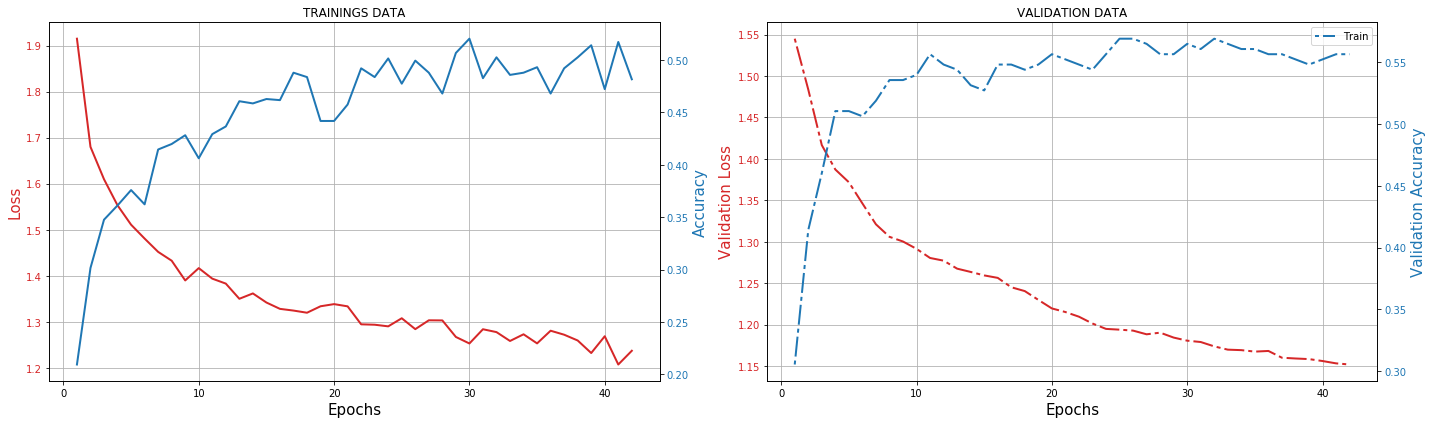

['loss', 'mean_squared_error', 'acc']
Train accuracy: [1.0937286955827046, 0.0919083341007656, 0.6063651593286588]
Test accuracy: [1.2131233502151375, 0.09968275414373641, 0.5714285718767267]


In [13]:
# Plot history 
plot_loss_acc(model)

# Reshape X_test data
reshaped_X_test = X_test.reshape(X_test.shape[0],-1)

# Evaluate the model
train_acc = model.evaluate(reshaped_X_train, y_train, verbose=0)
test_acc = model.evaluate(reshaped_X_test, y_test, verbose=0)
print(model.metrics_names)
print('Train accuracy: ' + str(train_acc))
print('Test accuracy: ' + str(test_acc))

In [14]:
y_predicted_classes = model.predict_classes(reshaped_X_test)
y_prediction_prob = model.predict(reshaped_X_test)

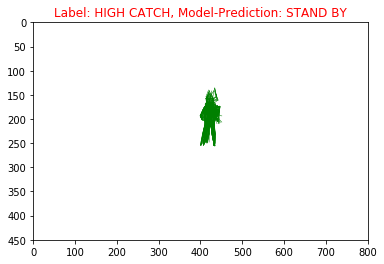

In [15]:
# Plot one sequence of poses and classify the containing exercises
plot_test_data(X_test, y_predicted_classes, y_test_temp, sample=69)

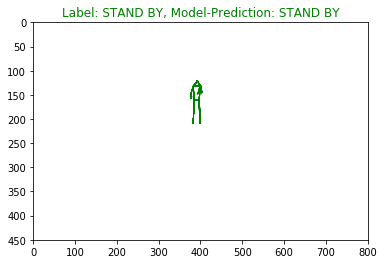

In [16]:
# Plot one sequence of poses and classify the containing exercises
plot_test_data(X_test, y_predicted_classes, y_test_temp, sample=14)

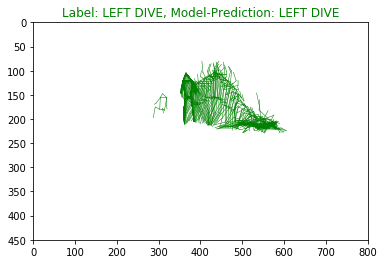

In [17]:
# Plot one sequence of poses and classify the containing exercises
plot_test_data(X_test, y_predicted_classes, y_test_temp, sample=9)

<h2> (8) Save model <h2>

In [18]:
# Save trained model
saved_model = model_directory + "/activity_recognition_model.h5"
model.save(saved_model)

In [19]:
# Convert trained model into CoreML
coreml_model = coremltools.converters.keras.convert(saved_model, 
                                                    class_labels=LABELS, 
                                                    input_names=['pose'])

# Store CoreML model 
coreml_model.save(model_directory + "/activity_recognition_model.mlmodel")

0 : reshape_1_input, <keras.engine.input_layer.InputLayer object at 0x7f71b2363a90>
1 : reshape_1, <keras.layers.core.Reshape object at 0x7f71b2363a58>
2 : LSTM_Layer1, <keras.layers.recurrent.LSTM object at 0x7f71b2363ac8>
3 : LSTM_Layer2, <keras.layers.recurrent.LSTM object at 0x7f71b2363d68>
4 : LSTM_Layer3, <keras.layers.recurrent.LSTM object at 0x7f71b2363ba8>
5 : Feature_Layer1, <keras.layers.core.Dense object at 0x7f71b2203f60>
6 : batch_normalization_1, <keras.layers.normalization.BatchNormalization object at 0x7f71b1e20fd0>
7 : activation_1, <keras.layers.core.Activation object at 0x7f71b1dc4b38>
8 : Feature_Layer2, <keras.layers.core.Dense object at 0x7f71b1c51cf8>
9 : batch_normalization_2, <keras.layers.normalization.BatchNormalization object at 0x7f71b236ba90>
10 : activation_2, <keras.layers.core.Activation object at 0x7f71b1e20908>
11 : Output_Layer, <keras.layers.core.Dense object at 0x7f732ddf9cf8>
12 : Output_Layer__activation__, <keras.layers.core.Activation object a

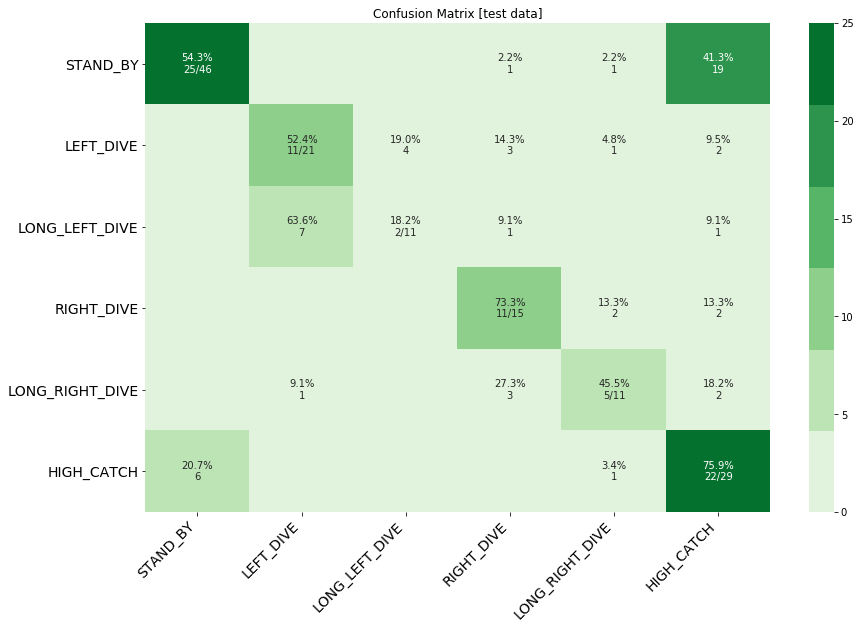

In [20]:
# Generate confusion matrix test data 
matrix = metrics.confusion_matrix(y_test_temp, y_predicted_classes, labels=np.unique(y_test_temp))
print_confusion_matrix(matrix, LABELS, figsize = (14,9), cmap=sn.color_palette("Greens"))